In [ ]:
%matplotlib inline

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
# for colab
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.1-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 483.0MB 1.2MB/s 
ERROR: torchvision 0.7.0+cu101 has requirement torch==1.6.0, but you'll have torch 0.4.1 which is incompatible.
ERROR: fastai 1.0.61 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101


In [ ]:
# for colab
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

ModuleNotFoundError: ignored

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1. Генерим датасет

In [4]:
import datetime
from random import randrange
from datetime import timedelta

In [5]:
def get_random_date(start, end):
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return (start + timedelta(seconds=random_second)).replace(hour=0, minute = 0, second=0)


FORMATS = ['%d %b %Y', '%d %B %Y', '%B %dth, %Y', '%b %d, %Y', 
           '%d/%m/%Y', '%d/%m/%y', '%d-%b-%y', '%d.%m.%Y']

TARGET_FORMAT = '%d-%m-%Y'

def get_dataset(fst_dt, snd_dt, fmt_dt):
    fst_d = datetime.datetime.strptime(fst_dt, fmt_dt)
    snd_d = datetime.datetime.strptime(snd_dt, fmt_dt)
    dataset = []
    for i in range(50000):
        date_format = random.choice(FORMATS)
        rand_dt = get_random_date(fst_d, snd_d)
        t = (datetime.datetime.strftime(rand_dt, date_format), 
            datetime.datetime.strftime(rand_dt, TARGET_FORMAT))
        dataset.append(t)
    return dataset
    
dataset = get_dataset('1/1/2017', '1/1/2019', '%m/%d/%Y')

In [6]:
dataset[:10]

[('29/07/2017', '29-07-2017'),
 ('06.03.2018', '06-03-2018'),
 ('26/10/2017', '26-10-2017'),
 ('06 March 2017', '06-03-2017'),
 ('29 January 2017', '29-01-2017'),
 ('29.03.2018', '29-03-2018'),
 ('24.06.2018', '24-06-2018'),
 ('26-Oct-17', '26-10-2017'),
 ('Jun 11, 2018', '11-06-2018'),
 ('Dec 04, 2017', '04-12-2017')]

### 2. Создаем вспомогательные классы для word2index, index2word

In [7]:
# длина самой большой строки + EOS
MAX_LENGTH = max(map(lambda x: len(x[0]), dataset)) + 1

In [8]:
SOS_token = 0
EOS_token = 1

# в нашем случае word является символом
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS and EOS

    def addSentence(self, sentence):
        for word in list(sentence):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1

In [9]:
def readLangs(lang1, lang2):
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    return input_lang, output_lang, dataset


def prepareData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('human', 'iso')
print(random.choice(pairs))

human 43
iso 13
('Jul 21, 2017', '21-07-2017')


### 3. The Seq2Seq Model
- модель, состоящая из двух RNN: encoder и decoder.  Encoder считывает предложение и выдает вектор (закодированное предложение), decoder считывает этот вектор и генерирует предложение.
- в конец исходного предложения добавляем EOS-символ (его векторное представление, получающееся после применения encoder - и есть вектор, который будем подавать в decoder)
- на вход decoder в качестве первого символа подается SOS-символ, а в качестве начального скрытого состояния подается эмбеддинг EOS-символа из encoder

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
# обычный декодер
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 4. Attention Decoder

Attention позволяет decoder-у смотреть на разные части предложения при генерации своего выхода. 
- вычисляем набор attention-весов 
- они умножаются на выход encoder-a(``attn_applied``) 


In [13]:
# attention декодер
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 5. Обучение
- создаем input-тензоры (с индексами символов) для каждой пары обучающей выборки
- добавляем EOS-символы и в source, и в target последовательность


In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in list(sentence)]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [15]:
# "Teacher forcing" - conception
# http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf
teacher_forcing_ratio = 0.5

# для одного входа
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = False
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [16]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(%d %d%%) %.4f' % (iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Plotting results

In [17]:
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### 6. Качество

In [18]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

Можно посмотреть на некоторую пару предложений из обучающей выборки и оценить качество.




In [19]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words)
        print('<', output_sentence)
        print('')

### 7. Запускаем обучение

In [ ]:
# # http://pytorch.org/
# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
# import torch

(500 1%) 1.6156
(1000 3%) 0.7222
(1500 5%) 0.6407
(2000 6%) 0.5516
(2500 8%) 0.4663
(3000 10%) 0.4009
(3500 11%) 0.3043
(4000 13%) 0.2455
(4500 15%) 0.1860
(5000 16%) 0.1733
(5500 18%) 0.1203
(6000 20%) 0.1029
(6500 21%) 0.1151
(7000 23%) 0.0993
(7500 25%) 0.0956
(8000 26%) 0.0757
(8500 28%) 0.0915
(9000 30%) 0.0755
(9500 31%) 0.0711
(10000 33%) 0.0753
(10500 35%) 0.0851
(11000 36%) 0.0760
(11500 38%) 0.0736
(12000 40%) 0.0578
(12500 41%) 0.0732
(13000 43%) 0.0598
(13500 45%) 0.0667
(14000 46%) 0.0611
(14500 48%) 0.0580
(15000 50%) 0.0561
(15500 51%) 0.0472
(16000 53%) 0.0524
(16500 55%) 0.0491
(17000 56%) 0.0579
(17500 58%) 0.0428
(18000 60%) 0.0538
(18500 61%) 0.0478
(19000 63%) 0.0430
(19500 65%) 0.0396
(20000 66%) 0.0441
(20500 68%) 0.0437
(21000 70%) 0.0349
(21500 71%) 0.0378
(22000 73%) 0.0255
(22500 75%) 0.0286
(23000 76%) 0.0315
(23500 78%) 0.0367
(24000 80%) 0.0271
(24500 81%) 0.0281
(25000 83%) 0.0275
(25500 85%) 0.1323
(26000 86%) 0.0408
(26500 88%) 0.0331
(27000 90%) 0.0236

<Figure size 432x288 with 0 Axes>

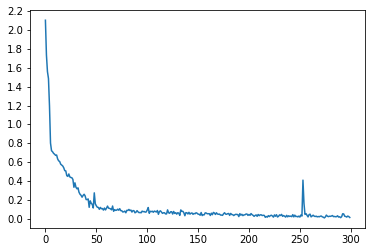

In [20]:
hidden_size = 64
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
trainIters(encoder1, attn_decoder1, 30000, print_every=500)

In [21]:
evaluateRandomly(encoder1, attn_decoder1)

> 09 Dec 2017
= 09-12-2017
< 09-12-2017<EOS>

> 03/02/17
= 03-02-2017
< 03-02-2017<EOS>

> November 23th, 2018
= 23-11-2018
< 23-11-2018<EOS>

> 19 Aug 2017
= 19-08-2017
< 19-08-2017<EOS>

> 27/09/2018
= 27-09-2018
< 27-09-2018<EOS>

> 19.02.2017
= 19-02-2017
< 19-02-2017<EOS>

> 09 Oct 2017
= 09-10-2017
< 09-10-2017<EOS>

> 23/05/17
= 23-05-2017
< 23-05-2017<EOS>

> 17/12/2017
= 17-12-2017
< 17-12-2017<EOS>

> 13.05.2018
= 13-05-2018
< 13-05-2018<EOS>



### 8. Визуализируем Attention

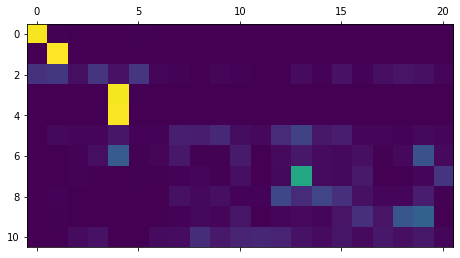

In [22]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "05 October 2017")
plt.matshow(attentions.numpy())

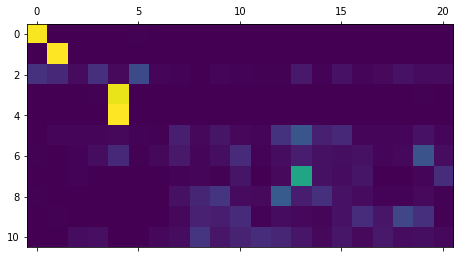

In [30]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "05.10.2017")
plt.matshow(attentions.numpy())

In [31]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + list(input_sentence) +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ''.join(list(output_words)))
    showAttention(input_sentence, output_words, attentions)

input = 05 October 2018
output = 05-10-2018<EOS>


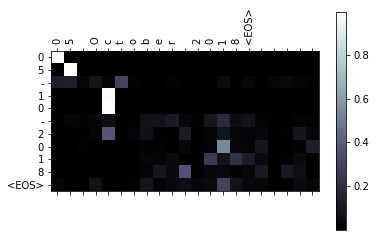

In [32]:
evaluateAndShowAttention("05 October 2018")

In [33]:
plt.clf()

<Figure size 432x288 with 0 Axes>

input = 04/01/2018
output = 04-01-2018<EOS>


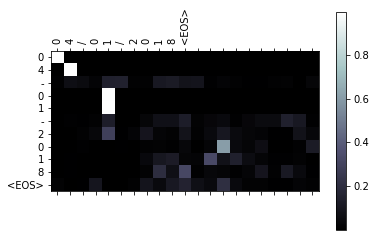

In [34]:
evaluateAndShowAttention("04/01/2018")

input = December 17th, 2018
output = 17-12-2018<EOS>


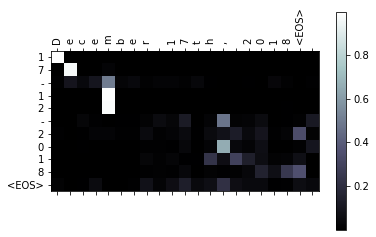

In [35]:
evaluateAndShowAttention("December 17th, 2018")

input = Feb 03, 2018
output = 01-02-2018<EOS>


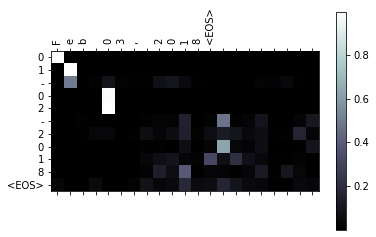

In [36]:
evaluateAndShowAttention("Feb 03, 2018")

### 9. Accuracy на тесте

In [37]:
dataset_test = get_dataset('1/1/2017', '1/1/2019', '%m/%d/%Y')

In [38]:
len(dataset_test)

50000

In [39]:
def accuracy_on_test(encoder, decoder, dataset_test):
    i = 0
    n = 0
    for pair in dataset_test:
        pred = []
        # pair[1] - target
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words)
        # output_sentence - pred
        n += 1
        i += int(output_sentence[:10]== pair[1][:10])
    return i*1. /n
        

In [40]:
accuracy_on_test(encoder1, attn_decoder1, dataset_test[:10000])

0.9517